# cleanup data and store for latter processing

To do:

- finish clean up ctd: 
    - [X] mecanism to distinguish between underway and cast
    - ask confirmation that we don't have more to Benji
- [X] go get wind data:
    - [X] arome
    - [ ] wind station 
- go get tide information (currents, sea level):
    - [X] tide gauge Ouistreham
    - [ ] smile ADCP data
- [ ] aller chercher les données satellite S2, SST
- process drifters1: 
    - [X] get wind data
    - [ ] produce movies of trajectories
    - [ ] produce movies of relative evolution


In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import xarray as xr

# cognac data and tools
# import cognac.insitu as iu
import pynsitu as pin

In [2]:
## taos
root_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos0/"

# taos0-drifters0
campaign = "taos0_drifters0"
yaml = f"drifters0/{campaign}.yaml"

# taos0-drifters1
campaign = "taos0_drifters1"
yaml = f"drifters1/{campaign}.yaml"

cp = pin.campaign(os.path.join(root_dir, yaml))

0-4351896
0-4351908
0-4352049
0-4351904
0-4352175
0-4352044
ctd_parceque
ctd_hydrophone
ship_hydrophone
ship_parceque


---

## drifters

`drifters_bin.csv` is a binary csv file and it was converted into an ascii csv file with:

```
cat drifters_bin.csv | tr -d '\0' > drifters.csv
```



In [3]:
def read_drifters(file):

    df = pd.read_csv(file, parse_dates=[1])
    df["DeviceDateTime"]

    df = df.rename(
        columns=dict(
            DeviceName="id",
            DeviceDateTime="time",
            Latitude="latitude",
            Longitude="longitude",
        )
    ).sort_values("id")
    # df["id"] = df["id"].map(lambda v: v.replace("-",""))
    df = df.set_index("id")

    return df

In [4]:
drifter_file = os.path.join(cp.pathr, "drifters.csv")
df = read_drifters(drifter_file)
df.head()

time BatteryStatus     CommId  GPS Confidence  \
id                                                                       
0-4351896 2022-05-18 06:17:21          GOOD  0-4351896               0   
0-4351896 2022-05-18 15:37:21          GOOD  0-4351896               0   
0-4351896 2022-05-17 23:12:20          GOOD  0-4351896               0   
0-4351896 2022-05-17 14:22:23          GOOD  0-4351896               0   
0-4351896 2022-05-19 03:37:24          GOOD  0-4351896               0   

           GPS Fail Counter  GpsQuality   latitude  longitude  
id                                                             
0-4351896                 0           3  49.413167  -0.389650  
0-4351896                 0           3  49.381120  -0.319612  
0-4351896                 0           3  49.368052  -0.244832  
0-4351896                 0           3  49.362044  -0.305364  
0-4351896                 0           3  49.380347  -0.279851

### compute and show typical time intervals

This is to decide on a reasonable target timeline.
A 2 minutes sampling rate seems reasonable.

In [5]:
df["dt"] = (
    df.groupby(df.index)
    .apply(lambda df: df.sort_values("time")["time"].diff() / pd.Timedelta("1m"))
    .droplevel(0)
)

# drop small time intervals
# df = df.loc[df.dt>3]

fig, ax = plt.subplots(1, 1)
df["dt"].plot.hist(bins=np.arange(0, 20, 0.5))
ax.set_yscale("log")
ax.grid()
ax.set_title("Time interval between positions")
ax.set_xlabel("minutes")

_frac = df["dt"].loc[np.abs(df.dt - 5) < 1].size / df["dt"].size
print(f"Percentage of time invervals between 4 and 6 minutes: {_frac*100:.0f}%")

Percentage of time invervals between 4 and 6 minutes: 93%


Show raw speed distribution (for despiking purposes)

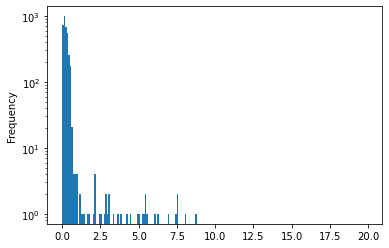

In [6]:
df_speed = (
    df.groupby(df.index)
    .apply(
        lambda df: df.sort_values("time")
        .set_index("time")
        .geo.compute_velocities(acceleration=True)
    )
    .droplevel(0)
)
fig, ax = plt.subplots(1, 1)
df_speed.velocity.plot.hist(bins=np.arange(0, 20, 0.1))
ax.set_yscale("log")

Acceleration:

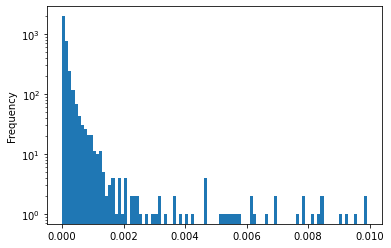

In [7]:
fig, ax = plt.subplots(1, 1)
# np.abs(df_speed["acc_x"]).plot.hist(bins=np.arange(0.,.01,1e-4))
# np.abs(df_speed["acc_y"]).plot.hist(bins=np.arange(0.,.01,1e-4))
np.abs(df_speed["acc"]).plot.hist(bins=np.arange(0.0, 0.01, 1e-4))
ax.set_yscale("log")
# 2/3600/6

Raw time series

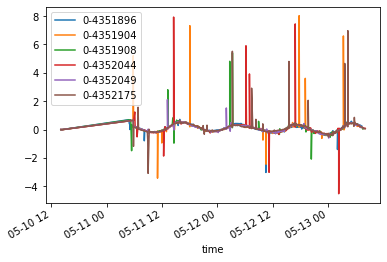

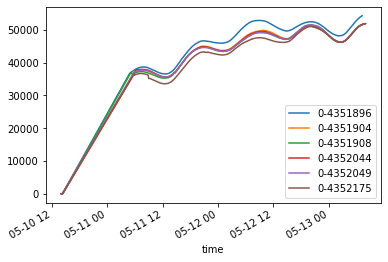

In [8]:
sl = slice(300, 400)
sl = slice(0, None)

fig, ax = plt.subplots(1, 1)
df_speed.groupby("CommId").apply(lambda df: df["velocity"].iloc[sl].plot())

fig, ax = plt.subplots(1, 1)
df_speed.groupby("CommId").apply(
    lambda df: df["ux"].iloc[sl].plot(label=df.name)
)  # .iloc[50:100]
ax.legend()
fig, ax = plt.subplots(1, 1)
df_speed.groupby("CommId").apply(
    lambda df: df["x"].iloc[sl].plot(label=df.name)
)  # .iloc[200:300]
ax.legend()

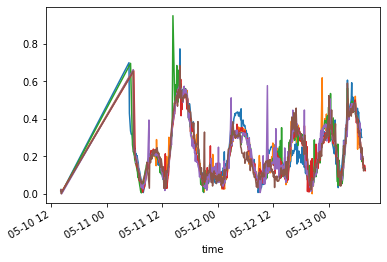

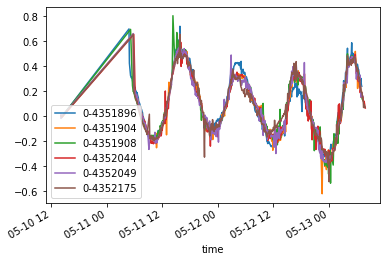

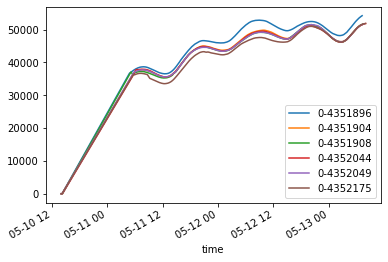

In [9]:
# drop high velocity values
# df_speed = df_speed.loc[df_speed.velocity.shift(-1)<2.]

# drop high acceleration values
_df_speed = df_speed.loc[df_speed.acc < 1e-3]

fig, ax = plt.subplots(1, 1)
_df_speed.groupby("CommId").apply(lambda df: df["velocity"].plot())

fig, ax = plt.subplots(1, 1)
_df_speed.groupby("CommId").apply(
    lambda df: df["ux"].plot(label=df.name)
)  # .iloc[50:100]
ax.legend()
fig, ax = plt.subplots(1, 1)
_df_speed.groupby("CommId").apply(
    lambda df: df["x"].plot(label=df.name)
)  # .iloc[200:300]
ax.legend()

Show an histogram of data in (dl, dt) space

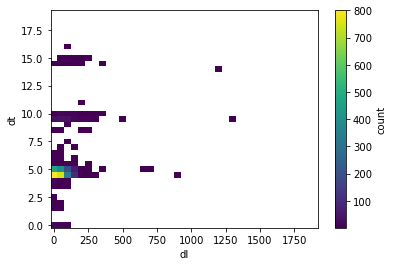

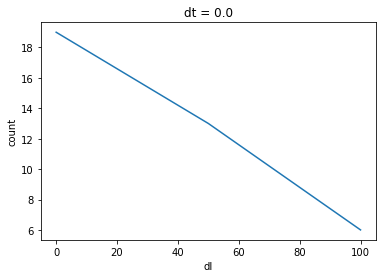

In [10]:
def dtdl_hist(df):
    # copy and project
    df = df.copy()
    df.geo.project()

    # define bins
    dt_bins = np.arange(0, 20, 0.5)  # in minutes
    dl_bins = np.arange(0, 2000, 50)  # in m

    # compute time and space steps
    df["dt"] = (
        df.groupby(df.index)
        .apply(lambda _df: _df.sort_values("time")["time"].diff() / pd.Timedelta("1m"))
        .droplevel(0)
    )
    df["dx"] = (
        df.groupby(df.index)
        .apply(lambda _df: _df.sort_values("time")["x"].diff())
        .droplevel(0)
    )
    df["dy"] = (
        df.groupby(df.index)
        .apply(lambda _df: _df.sort_values("time")["y"].diff())
        .droplevel(0)
    )
    df["dl"] = np.sqrt(df.dx**2 + df.dy**2)

    # cut prior to grouping
    df["dt_cut"] = pd.cut(df.dt, dt_bins)
    df["dl_cut"] = pd.cut(df.dl, dl_bins)
    # count
    dfc = df.groupby(["dt_cut", "dl_cut"]).count()["dx"].reset_index()
    # massage and convert to xarray
    dfc.loc[:, ["dt", "dl"]] = dfc.apply(
        lambda row: pd.Series(dict(dt=row["dt_cut"].left, dl=row["dl_cut"].left)),
        axis=1,
    )
    da = dfc.set_index(["dt", "dl"])["dx"].to_xarray().rename("count")
    da = da.where(da > 0)

    return da


da = dtdl_hist(df)
da.plot()

fig, ax = plt.subplots(1, 1)
da.isel(dt=0).plot()

At lag 0, the mode of the spatial spacing is 200m.

Velocity associated with a 300m error over 10 minutes:

In [27]:
dl = 200  # meters
dt = 10  # minutes
print(f"speed error={dl/(dt*60):.2f} m/s for dt={dt} min and dl={dl} m")

speed error=0.33 m/s for dt=10 min and dl=200 m


### denoise based on acceleration with a threshold of 0.001 m^2/s

In [12]:
def _denoise(df):
    df.geo.project()
    # drop times that are two close
    df = df.set_index("time").geo.compute_velocities(acceleration=True)
    return df.loc[df.acc < 1e-3]


df_denoised = (
    df.groupby("id")
    .apply(_denoise)
    .reset_index()
    .set_index("id")
    .drop(columns=["x", "y", "ux", "uy", "velocity", "acc_x", "acc_y", "acc"])
)
df_denoised.head()

time BatteryStatus     CommId  GPS Confidence  \
id                                                                       
0-4351896 2022-05-11 11:10:15          GOOD  0-4351896               0   
0-4351896 2022-05-12 23:55:06          GOOD  0-4351896               0   
0-4351896 2022-05-12 12:10:07          GOOD  0-4351896               0   
0-4351896 2022-05-11 20:05:07          GOOD  0-4351896               0   
0-4351896 2022-05-11 11:15:09          GOOD  0-4351896               0   

           GPS Fail Counter  GpsQuality   latitude  longitude  
id                                                             
0-4351896                 0           3  49.342475  -0.244145  
0-4351896                 0           3  49.337325  -0.068836  
0-4351896                 0           3  49.342614  -0.048473  
0-4351896                 0           3  49.320652  -0.113940  
0-4351896                 0           3  49.342829  -0.244746

### filter data, compute velocities

We target a 20 minute time line.
This is a consequence of the substantial noise observed on velocities at 10minutes

In [13]:
rule = "20T"  # 20 m


def _resample(df):
    df = df.sort_values("time").set_index("time")
    df = df.geo.resample(rule)  # , interpolate=True
    # interpolate
    df = df.geo.resample(rule, interpolate=True)
    # assert df.geo._geo_proj_ref, "no geo proj ref" # as it should
    # add velocity
    df = df.geo.compute_velocities()
    return df.reset_index("time")


dfi = df_denoised.groupby("id").apply(_resample).droplevel(1)

### extract drifter ids and test if both ids sources are identical

In [14]:
ids = list(df.index.unique())
ids_cp = [u for u in cp if "0-435" in u]
set(ids) == set(ids_cp)

True

In [15]:
i = ids_cp[2]
print(i)
dfi.loc[i].geo.plot_bokeh(unit=cp[i])

0-4352049


Loading BokehJS ...

### trim data and concatenate back

The output below is used to adjust the campaign yaml file

In [16]:
D = []
for i in ids:
    _df = dfi.loc[i].set_index("time")
    for d in cp[i]:
        print("----")
        _dft = _df.geo.trim(d)
        _dft.loc[:, "deployment"] = d.label
        _dft.loc[:, "id"] = i
        start = _dft.iloc[0][["longitude", "latitude"]]
        end = _dft.iloc[-1][["longitude", "latitude"]]
        print(
            i,
            d.label,
            f"start = {start.name}  {start.longitude:.4f}  {start.latitude:.4f}",
        )
        print(
            i,
            d.label,
            f"end = {end.name}  {end.longitude:.4f}  {end.latitude:.4f}",
        )
        D.append(_dft)

dfit = pd.concat(D, axis=0).reset_index().set_index("id")
dfit.head()

----
0-4351896 d0 start = 2022-05-11 05:20:00  -0.2391  49.3393
0-4351896 d0 end = 2022-05-13 07:00:00  -0.0066  49.3635
----
0-4351904 d0 start = 2022-05-11 06:00:00  -0.2408  49.3390
0-4351904 d0 end = 2022-05-13 07:20:00  -0.0414  49.3493
----
0-4351908 d0 start = 2022-05-11 05:40:00  -0.2479  49.3305
0-4351908 d0 end = 2022-05-13 07:20:00  -0.0409  49.3496
----
0-4352044 d0 start = 2022-05-11 06:00:00  -0.2338  49.3487
0-4352044 d0 end = 2022-05-11 06:20:00  -0.2323  49.3481
----
0-4352044 d1 start = 2022-05-11 06:40:00  -0.2321  49.3472
0-4352044 d1 end = 2022-05-13 08:00:00  -0.0386  49.3515
----
0-4352049 d0 start = 2022-05-11 06:00:00  -0.2407  49.3390
0-4352049 d0 end = 2022-05-13 07:20:00  -0.0411  49.3495
----
0-4352175 d0 start = 2022-05-11 06:00:00  -0.2521  49.3387
0-4352175 d0 end = 2022-05-11 08:40:00  -0.2586  49.3391
----
0-4352175 d1 start = 2022-05-11 09:20:00  -0.2712  49.3450
0-4352175 d1 end = 2022-05-13 07:20:00  -0.0404  49.3497


/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


time  GPS Confidence  GPS Fail Counter  GpsQuality  \
id                                                                            
0-4351896 2022-05-11 05:20:00             0.0               0.0         3.0   
0-4351896 2022-05-11 05:40:00             0.0               0.0         3.0   
0-4351896 2022-05-11 06:00:00             0.0               0.0         3.0   
0-4351896 2022-05-11 06:20:00             0.0               0.0         3.0   
0-4351896 2022-05-11 06:40:00             0.0               0.0         3.0   

            latitude  longitude             x           y        ux        uy  \
id                                                                              
0-4351896  49.339275  -0.239097  37315.451777   20.908821  0.326280 -0.095844   
0-4351896  49.338441  -0.234511  37649.415596  -69.595728  0.278303 -0.075420   
0-4351896  49.337626  -0.230471  37943.586508 -158.214275  0.245142 -0.073849   
0-4351896  49.336866  -0.227135  38186.651298 -240.972316  0.202554 -0.068965   
0-4351896  49.336095  -0.224233  38398.179406 -325.312027  0.176273 -0.070283   

           velocity deployment  
id                              
0-4351896  0.340066         d0  
0-4351896  0.288342         d0  
0-4351896  0.256024         d0  
0-4351896  0.213973         d0  
0-4351896  0.189768         d0

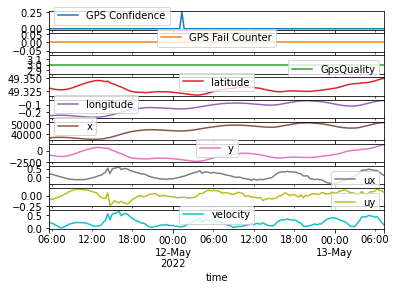

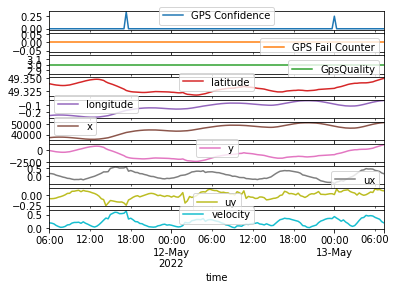

In [17]:
for i in ids:
    dfit.loc[i].set_index("time").plot(subplots=True)  # x="longitude", y="latitude"

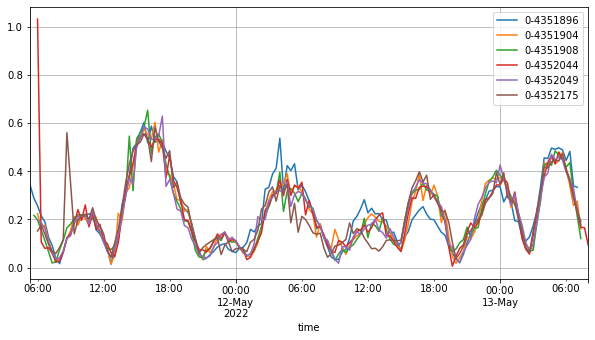

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in ids:
    dfit.loc[i].set_index("time")["velocity"].plot(
        label=i
    )  # x="longitude", y="latitude"
ax.legend()
ax.grid()

### overview map of the trajectories

In [19]:
# bounds=[-.5, -.1, 49.25, 49.5]
if campaign == "taos0_drifters0":
    bounds = [-0.4, 0.0, 49.25, 49.4]  # taos0-drifters0
elif campaign == "taos0_drifters1":
    bounds = [-0.45, -0.15, 49.25, 49.45]  # taos0-drifters1

_df = dfit.reset_index().set_index(["id", "deployment"])

fig, ax, crs = cp.plot_map(bounds=bounds, coast="bseine", land=None, rivers="bseine")

keys = _df.groupby(_df.index).groups.keys()
colors = pin.get_cmap_colors(len(keys))

for k, c in zip(keys, colors):
    _dfk = _df.groupby(_df.index).get_group(k).reset_index().dropna(axis=1)
    ax.plot(_dfk.longitude, _dfk.latitude, color=c, transform=crs, label=", ".join(k))
    ax.scatter(
        _dfk.longitude.iloc[0],
        _dfk.latitude.iloc[0],
        color=c,
        transform=crs,
        edgecolor="k",
        s=100,
        zorder=10,
        marker="o",
    )
    ax.scatter(
        _dfk.longitude.iloc[-1],
        _dfk.latitude.iloc[-1],
        color=c,
        transform=crs,
        edgecolor="k",
        s=200,
        zorder=10,
        marker="*",
    )

ax.legend()

/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


In [20]:
# store
dfit.to_xarray().to_netcdf(os.path.join(cp.pathp, "drifters.nc"), mode="w")

---

## ctd, underway, cast

Very convenient the GPS logging !

**taos0 - drifters0**

- First day, the first ctd deployment (d0) is noisy for salinity with fluctuations with period of less that 10s. Do we see this for other deployments? We apply a median filter for now
- Second day: salinity is less noisy

**taos0 - drifters1**

- First day - hydrophone: 
    - no gps position during half of first cast: ctd turned on too late?
    - takes about 45s for the conductivity to reach equilibrium, several downcast did not wait long enough
   
Keep only downcast (because slower than upcast) for CTD profiless


In [14]:
def read_sonde_lern(file, tz_offset=0, stype=0):
    """Load LERN CTD data"""

    with open(file, encoding="unicode_escape") as f:
        d = list(f.readlines())

    # replace NUL, strip whitespace from the end of the strings, split each string into a list
    d = [v.replace("\x00", "").strip().replace(",", ".").split("\t") for v in d]

    # remove some empty rows
    d = [v for v in d if len(v) > 1]

    # d[0]:
    # ['Date', 'Time', 'Site', 'Unit ID', 'User ID',
    # '°C-19K104425', 'mmHg-19C102825', 'DO %-20A103151', 'DO mg/L-20A103151',
    # 'C-mS/cm-19K104425', 'SAL-PSU-19K104425', 'FNU-19M102353',
    # 'Chl RFU-19M101982', 'Chl ug/L-19M101982',
    # 'DEP m-19K105267']

    # benji deployments
    # ['Date', 'Time', 'Site', 'Unit ID', 'User ID',
    # '°C-21A101173', 'mmHg-20L100404', 'DO %-21A100555', 'DO mg/L-21A100555',
    # 'C-mS/cm-21A101173', 'SAL-PSU-21A101173',
    # 'DEP m-20H100561']

    if stype == 0:
        columns = [
            "Date",
            "Time",
            "Site",
            "Unit ID",
            "User ID",
            "temperature",
            "air_pressure",
            "DO_p",
            "DO_mgL",
            "conductivity",
            "salinity",
            "FNU",
            "Chl_RFU",
            "Chl_ugL",
            "depth",
            "latitude",
            "longitude",
        ]
    elif stype == 1:
        columns = [
            "Date",
            "Time",
            "Site",
            "Unit ID",
            "User ID",
            "temperature",
            "air_pressure",
            "DO_p",
            "DO_mgL",
            "conductivity",
            "salinity",
            "depth",
            "latitude",
            "longitude",
        ]

    df = pd.DataFrame(d[1:], columns=columns)

    # convert column 0 and 1 to a datetime
    df["time"] = (
        pd.to_datetime(df["Date"] + " " + df["Time"]) + pd.Timedelta("1H") * tz_offset
    )

    df.set_index("time", inplace=True)
    df = df.drop(columns=["Date", "Time", "Site", "Unit ID", "User ID"])

    df = df.astype("float")

    # convert air pressure from mmHg to bar
    df["air_pressure"] = df["air_pressure"] / 750.06

    return df

**Parceque**

In [40]:
u, stype = "ctd_parceque", 0  # franck - check

case = 0
if case == 0:
    # taos0-drifters0, day 0
    ctd_path = os.path.join(cp.pathr, u + "_11052022.csv")
    labels = [f"u{i}" for i in range(4)]
elif case == 1:
    # taos0-drifters0, day 1  !!!! not cleaned ?
    ctd_path = os.path.join(cp.pathr, u + "_13052022.csv")
    labels = [f"u{i}" for i in range(4, 7)]
elif case == 2:
    # taos0-drifters1, day 0
    ctd_path = os.path.join(cp.pathr, u + "_17052022.csv")
    labels = ["u0"]
elif case == 3:
    # taos0-drifters1, day 1
    ctd_path = os.path.join(cp.pathr, u + "_19052022.csv")
    labels = ["u1"]

**Hydrophone**

In [16]:
u, stype = "ctd_hydrophone", 1  # benji

case = 2
if case == 0:
    # taos0-drifters0, day 0  !!! no valid CTD
    pass
elif case == 1:
    # taos0-drifters0, day 1  !!! no valid CTD
    pass
elif case == 2:
    # taos0-drifters1, day 0
    ctd_path = os.path.join(cp.pathr, u + "_17052022.csv")
    labels = [f"c0_{i}" for i in range(15)]
elif case == 3:
    # taos0-drifters1, day 1
    ctd_path = os.path.join(cp.pathr, u + "_19052022.csv")
    labels = [f"c1_{i}" for i in range(9)]

In [41]:
df = read_sonde_lern(ctd_path, tz_offset=-2, stype=stype)

df.sw.plot_bokeh(unit=cp[u])

Loading BokehJS ...

# trim, filter and store

In [42]:
D = {}
for d in cp[u]:
    if (isinstance(labels, str) and labels == "all") or d.label in labels:
        # trim first to exclude irrelevant values
        _df = df.sw.trim(d)
        if d.label[0] == "u":
            # underway data
            print(d, "underway processing")
            _df = _df.sw.resample("20s", op="median")
        elif d.label[0] == "c":
            print(d, "cast processing")
            _df = _df.sw.compute_vertical_profile(1.0)
        D[d.label] = _df
    else:
        print(f"skipping {d.label}")

u0 / start 2022-05-11 05:39:00 -0.22 49.36 / end 2022-05-11 07:03:00 -0.24 49.33 underway processing
u1 / start 2022-05-11 07:06:00 -0.23 49.33 / end 2022-05-11 07:07:00 -0.23 49.33 underway processing
u2 / start 2022-05-11 07:09:20 -0.22 49.32 / end 2022-05-11 07:11:10 -0.22 49.32 underway processing
u3 / start 2022-05-11 07:16:38 -0.26 49.32 / end 2022-05-11 07:18:00 -0.26 49.32 underway processing
skipping u4
skipping u5
skipping u6


/Users/aponte/Code/pynsitu/pynsitu/seawater.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SA'] = gsw.SA_from_SP(s, p, self._lon, self._lat)
/Users/aponte/Code/pynsitu/pynsitu/seawater.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CT'] = gsw.CT_from_t(df.SA, t, p)
/Users/aponte/Code/pynsitu/pynsitu/seawater.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

### store

In [43]:
for d, _df in D.items():
    _df.to_xarray().to_netcdf(os.path.join(cp.pathp, f"{u}_{d}.nc"), mode="w")

### various plots

/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


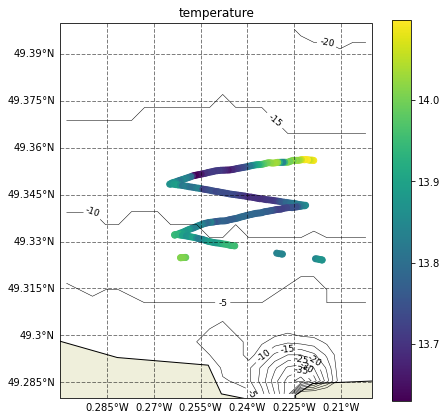

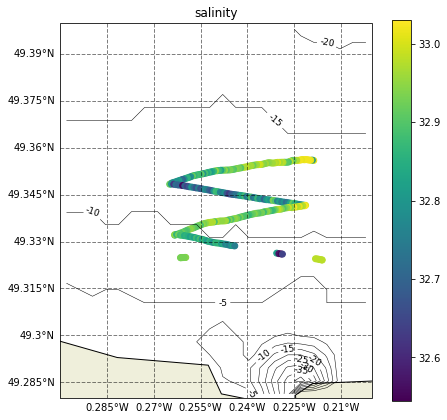

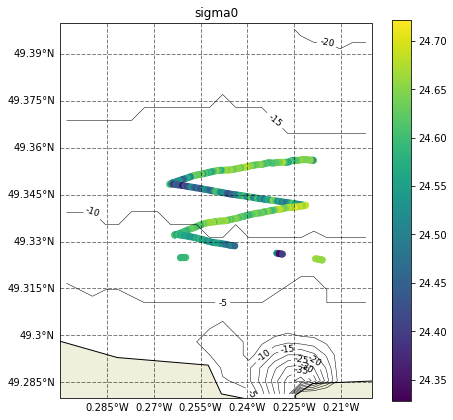

In [44]:
if case == 0:
    bounds = [-0.3, -0.2, 49.28, 49.4]  # drifters0 - first day
elif case == 1:
    bounds = [-0.1, 0.0, 49.28, 49.4]  # drifters0 - second day


def scatter(v, **kwargs):
    """produce scatter plot"""
    # compute global bounds
    vmin, vmax = _global_bounds(v)
    dkwargs = dict(vmin=vmin, vmax=vmax)
    dkwargs.update(**kwargs)

    fig, ax, crs = cp.plot_map(
        bounds=bounds,
        coast="bseine",
        land=None,
        # coast="bseine", land=None, rivers="bseine",
        figsize=(7, 7),
    )
    for d, _df in D.items():
        # _df = _df.sw.resample("10s")
        im = ax.scatter(
            _df.longitude, _df.latitude, c=_df[v], transform=crs, label=v, **dkwargs
        )
    ax.set_title(v)
    cbar = fig.colorbar(im)
    cbar.formatter.set_useOffset(False)


def _global_bounds(v):
    _min = min([_df[v].min() for d, _df in D.items()])
    _max = max([_df[v].max() for d, _df in D.items()])
    return _min, _max


cbar = scatter("temperature")  # vmin=13.8, vmax=14.1
cbar = scatter("salinity")
cbar = scatter("sigma0")
cbar = scatter("Chl_ugL", vmax=5)

In [45]:
slim, tlim = (32.5, 33.2), (13.6, 14.4)  # drifters0 - day 1
slim, tlim = (32.5, 33.2), (13.9, 15.2)  # drifters0 - day 2

fig, ax = pin.plot_ts(slim, tlim)
colors = pin.get_cmap_colors(len(D))
for d, c in zip(D, colors):
    _df = D[d]
    ax.scatter(_df.salinity, _df.temperature, c=c)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [14]:
# concatenate data back and show histograms
df = pd.concat([df for d, df in D.items()], axis=0)
df.hist(bins=50, figsize=(20, 10))

array([[<AxesSubplot:title={'center':'temperature'}>,
        <AxesSubplot:title={'center':'pressure'}>,
        <AxesSubplot:title={'center':'DO_p'}>,
        <AxesSubplot:title={'center':'DO_mgL'}>],
       [<AxesSubplot:title={'center':'conductivity'}>,
        <AxesSubplot:title={'center':'salinity'}>,
        <AxesSubplot:title={'center':'FNU'}>,
        <AxesSubplot:title={'center':'Chl_RFU'}>],
       [<AxesSubplot:title={'center':'Chl_ugL'}>,
        <AxesSubplot:title={'center':'depth'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>],
       [<AxesSubplot:title={'center':'SA'}>,
        <AxesSubplot:title={'center':'CT'}>,
        <AxesSubplot:title={'center':'sigma0'}>, <AxesSubplot:>]],
      dtype=object)

### CTD cast

In [51]:
def plot_profiles(D, v, offset):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    colors = pin.get_cmap_colors(len(D))

    i = 0
    for d, df in D.items():
        off = offset * i
        ax.plot(df[v] + off, df.index, color=colors[i], lw=3)
        # ax.axvline(off)
        i += 1

    ax.grid()
    ax.set_title(v)

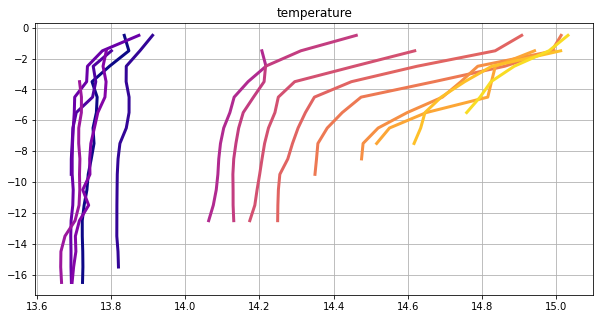

In [56]:
plot_profiles(D, "temperature", 0.0)

In [55]:
plot_profiles(D, "salinity", 0.0)

---

## ships


**taos0-drifters1:** Missing data files for second day

In [26]:
def load_ship(file, correct_day=None):
    """load ship (hydrophone, parceque) data

    Parameters
    ----------
    file: str
        path to data file
    correct_day: tuple, optional
        fix day of first data point (year, month, day)
    """
    with open(file, encoding="unicode_escape") as f:
        d = list(f.readlines())

    # replace NUL, strip whitespace from the end of the strings, split each string into a list
    d = [v.replace("\n", "").split(",") for v in d]

    columns = d[0]
    # print(columns)
    # ['ID', 'trksegID', 'lat', 'lon', 'ele', 'time', 'magvar', 'geoidheight', 'name', 'cmt', 'desc', 'src', 'sym', 'type', 'fix', 'sat', 'hdop', 'vdop', 'pdop', 'ageofdgpsdata', 'dgpsid', 'Temperature', 'Depth', 'wtemp', 'hr', 'cad', '']

    df = pd.DataFrame(d[1:], columns=columns)
    df["time"] = pd.to_datetime(df["time"])

    # fix day
    if correct_day:
        if isinstance(correct_day, dict):
            day = pd.Timestamp(**correct_day, tz="UTC")
        else:
            # assumes Timestamp
            day = correct_day
        t0 = df["time"][0]
        dt = day - t0.round("1D")
        print(f"Fix first time from {t0} to {t0 + dt}")
        df["time"] = (df["time"] + dt).dt.tz_localize(
            None
        )  # drop timezone as well (xarray complications down the line)

    # only keep non zero columns
    selected_columns = ["time", "lon", "lat", "Depth", "Temperature"]
    df = df[selected_columns].set_index("time").replace("", "0").astype("float")

    # rename critical columns
    df = df.rename(
        columns=dict(
            lon="longitude",
            lat="latitude",
            Depth="water_depth",
            Temperature="air_temperature",
        )
    )

    return df

In [32]:
deployments = [d.label for d in list(cp["ship_hydrophone"])]

d = deployments[0]  # d0
# d = deployments[1] # d1
print(f"deployment {d}")

file_p = os.path.join(cp.pathr, cp["ship_parceque"][d].info["file"])
file_h = os.path.join(cp.pathr, cp["ship_hydrophone"][d].info["file"])

cday = dict(year=2022, month=5, day=11)
cday = cp["ship_parceque"][d].start.time.round("1D").tz_localize("UTC")

df_p = load_ship(file_p, correct_day=cday)
df_h = df = load_ship(file_h, correct_day=cday)

deployment d0
Fix first time from 2002-10-01 07:17:39+00:00 to 2022-05-17 07:17:39+00:00
Fix first time from 2002-10-01 07:33:15+00:00 to 2022-05-17 07:33:15+00:00


### store

In [33]:
for df, label in zip([df_h, df_p], ["hydrophone", "parceque"]):
    (df.to_xarray().to_netcdf(os.path.join(cp.pathp, f"ship_{label}_{d}.nc"), mode="w"))

### plot

In [34]:
df_h.geo.plot_bokeh(unit=cp["ship_hydrophone"])
df_h.geo.plot_bokeh_map()

Loading BokehJS ...

Loading BokehJS ...

In [35]:
df_p.geo.plot_bokeh(unit=cp["ship_parceque"])
df_p.geo.plot_bokeh_map()

Loading BokehJS ...

Loading BokehJS ...

/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


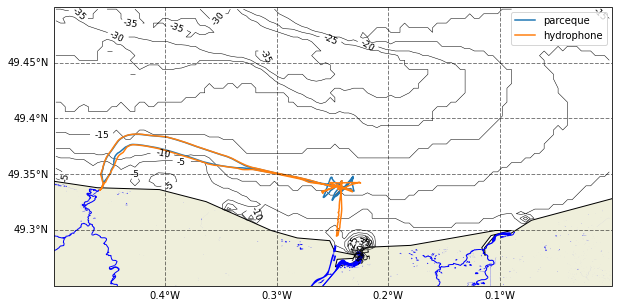

In [36]:
bounds = [-0.5, -0.1, 49.25, 49.5]
bounds = [-0.5, 0.0, 49.25, 49.5]
fig, ax, crs = cp.plot_map(bounds=bounds, coast="bseine", land=None, rivers="bseine")

ax.plot(df_p.longitude, df_p.latitude, transform=crs, label="parceque")
ax.plot(df_h.longitude, df_h.latitude, transform=crs, label="hydrophone")

ax.legend()

Inspect typical time interval between ship positions.

Typically around 10 seconds

Text(0.5, 1.0, 'Time interval between positions in seconds')

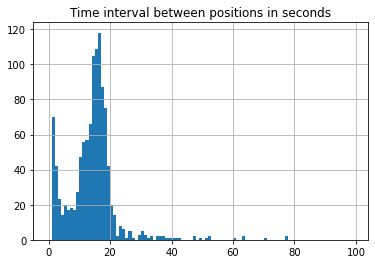

In [37]:
_df = df_p.reset_index()
_df["dt"] = _df["time"].diff() / pd.Timedelta("1s")
_df["dt"].hist(bins=np.arange(0, 100, 1))
plt.title("Time interval between positions in seconds")

---

## observed and modelled sea level and tidal currents

In [ ]:
import taos.utils as ut

dsh = ut.predict_tides(_ds.date_start, real=False, summed=False)

----

## wind, arome

To be done on datarmor.
Copy extracted netcdf file back on laptop.


In [2]:
import xarray as xr
import pandas as pd
from glob import glob

In [3]:
arome_dir = "/home/ref-oc-intranet-restricted/modeles_mf/arome_v2/best_estimate/"


def load_arome(t, dt=None, freq="1H", rkwargs={}, **kwargs):
    """Extract ERA data
    https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5

    Parameters
    ----------
    t: date-like object
        date for extraction
    dt: tuple, optional
        time interval in days around t
    freq: str
        frequency of outputs selected, e.g. "1H" or "1D"
    rkwargs: dict
        passed to load_dataset
    **kwargs: passed for direct selection
    """

    t = pd.to_datetime(t)
    if dt is not None:
        t = [t + pd.Timedelta(days=_dt) for _dt in range(*dt)]
        t = pd.date_range(t[0], t[-1], freq=freq)
    else:
        t = [t]

    #
    D = []
    for _t in t:
        _rpath = f"{_t.year}/METEOFRANCE_AROME_{_t.year}{_t.month:02d}{_t.day:02d}T{_t.hour:02d}Z*.nc"
        files = glob(os.path.join(arome_dir, _rpath))
        _ds = xr.merge(
            [xr.load_dataset(f, **rkwargs).squeeze().sel(**kwargs) for f in files]
        )
        D.append(_ds)
    ds = xr.concat(D, dim="time")

    return ds

In [4]:
# taos0-drifters0
t = pd.Timestamp(2022, 5, 12)
label = "taos0-drifters0"
# taos0-drifters1
t = pd.Timestamp(2022, 5, 19)
label = "taos0-drifters1"

ds = load_arome(
    t,
    dt=(
        -30,
        5,
    ),
    longitude=slice(-2, 2),
    latitude=slice(48, 50),
).chunk(dict(time="auto"))

nc = os.path.join(os.getenv("SCRATCH"), label + "_arome.nc")
ds.to_netcdf(nc, mode="w")

### quick overview

In [5]:
ds = cp.load("arome.nc")

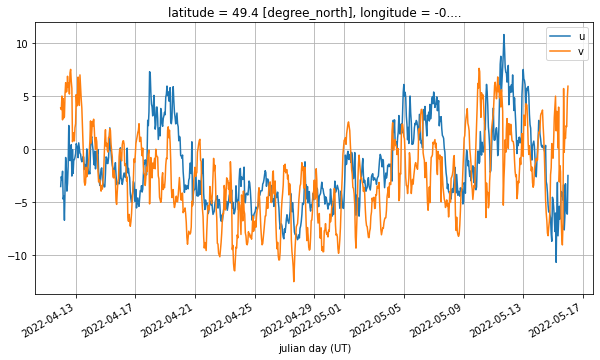

In [13]:
_ds = ds.sel(longitude=-0.2, latitude=49.4, method="nearest")

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
_ds.u10m.plot(label="u")
_ds.v10m.plot(label="v")
ax.grid()
ax.set_ylabel("")
ax.legend()

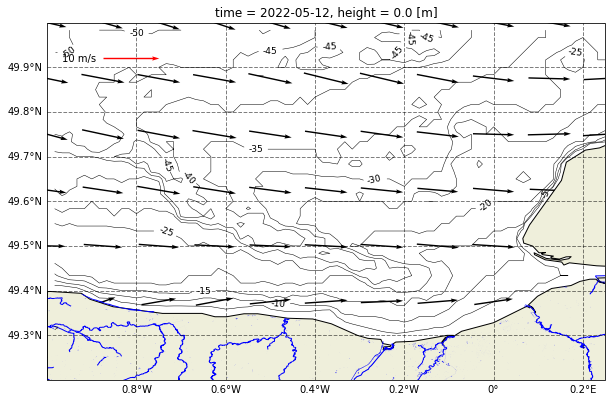

In [42]:
bounds = [-0.5, -0.1, 49.25, 49.5]
bounds = [-1.0, 0.25, 49.2, 50.0]
fig, ax, crs = cp.plot_map(bounds=bounds, coast="bseine", land=None, rivers="bseine")

di = 5
_ds = ds.sel(time="2022-05-12 00:00:00").isel(
    longitude=slice(0, None, di), latitude=slice(0, None, di)
)

q = _ds.plot.quiver(
    x="longitude", y="latitude", u="u10m", v="v10m", scale=1e2, transform=crs, zorder=-2
)
qk = ax.quiverkey(
    q,
    0.1,
    0.9,
    10,
    "10 m/s",
    transform=crs,
    color="r",
    labelpos="W",
    coordinates="axes",
    zorder=10,
)

---

## river discharges

---

## tides, sea level/currents



In [3]:
tgauge_dir = "/Users/aponte/Data/tides/maregraphe"

In [4]:
from glob import glob

tgauge_files = sorted(glob(os.path.join(tgauge_dir, "*.nc")))

ds = xr.open_dataset(tgauge_files[-1])

ds = ds.rename(
    dict(
        TIME="time",
        LATITUDE="latitude",
        LONGITUDE="longitude",
        Source1="sea_level",
    )
)

# demean sea level
ds["sea_level"] = ds["sea_level"] - ds["sea_level"].mean("time")

In [5]:
dt = ds.time.diff("time") / pd.Timedelta("1s")
print(f" min(dt)= {float(dt.min())} max(dt)= {float(dt.max())} ")

 min(dt)= 60.0 max(dt)= 10106.0 


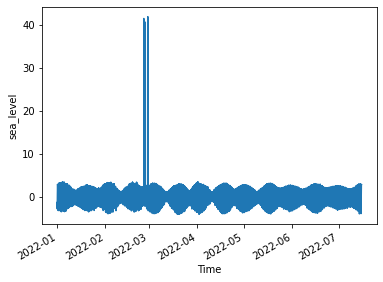

In [6]:
ds.sea_level.plot()

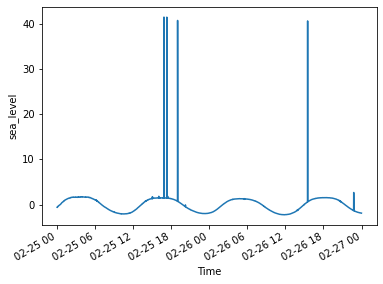

In [57]:
ds.sel(time=slice("2022-02-25", "2022-02-26")).sea_level.plot()

In [43]:
# dsr = ds.sel(time=slice(cp.start - pd.Timedelta("10D"), cp.end + pd.Timedelta("10D"))).resample(time="10T").mean()
dsr = ds.sel(time="2022").resample(time="10T").mean()

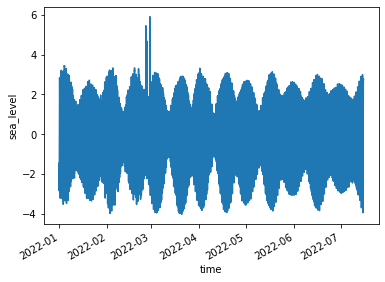

In [44]:
dsr.sea_level.sel(time="2022-05").plot(figsize=(15, 5))

/var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/ipykernel_13691/2428150208.py:4: UserWarning: registration of accessor <class '__main__.TimeSeriesAccessor'> under name 'ts' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class TimeSeriesAccessor:


In [45]:
df = dsr.to_dataframe()
df.ts.time_physical()
df.head()

latitude  longitude  sea_level        timep
time                                                             
2022-01-01 00:00:00  49.279362   -0.24903  -1.461973  378691200.0
2022-01-01 00:10:00  49.279362   -0.24903  -1.644713  378691800.0
2022-01-01 00:20:00  49.279362   -0.24903  -1.793523  378692400.0
2022-01-01 00:30:00  49.279362   -0.24903  -1.939423  378693000.0
2022-01-01 00:40:00  49.279362   -0.24903  -2.078783  378693600.0

In [46]:
cst = ["O1", "K1", "M2", "S2"]

c = load_equilibrium_constituents()
cst = [
    c.upper() for c in list(c.sort_values("amplitude", ascending=False).iloc[:].index)
]
cst = [
    c
    for c in cst
    if c
    not in [
        "MF",
        "MM",
        "SSA",
        "NU2",
        "MU2",
        "EPS2",
        "MSF",
        "LAMBDA2",
        "MSQM",
        "SA",
        "MTM",
    ]
]
print(cst)

# cst = cst + ["M4", "MS4"]

df.ts.tidal_analysis("sea_level", constituents=cst)

['M2', 'K1', 'S2', 'O1', 'P1', 'N2', 'K2', 'Q1', 'J1', 'L2', 'T2', '2N2', 'MN4', 'M4', 'MS4', 'M6', 'M3', 'R2', 'S1', 'S4', 'MKS2', 'N4', 'M8']


/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/matplotlib/text.py:830: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(self._x))
/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/matplotlib/text.py:690: ComplexWarning: Casting complex values to real discards the imaginary part
  posx = float(self.convert_xunits(self._x))


/var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/ipykernel_13691/2428150208.py:220: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  v =  ( f * np.exp(1j*vu) * np.conj(har[:,None]) ).sum(axis=0)


<AxesSubplot:xlabel='time'>

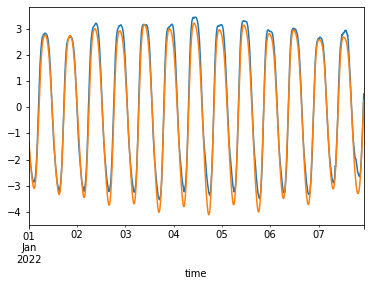

In [47]:
df["sea_level_tide"] = df.ts.tidal_predict("sea_level")

sl = slice(0, 1000)
# sl = slice(0,None)

df["sea_level"].iloc[sl].plot()
df["sea_level_tide"].iloc[sl].plot()

In [50]:
# store
dsr.to_netcdf(os.path.join(cp.pathp, f"sea_level.nc"), mode="w")

In [ ]:
---

## bouées

In [58]:
b_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos0/drifters1/coriolis"

file = os.path.join(b_dir, "mooring-buoys-time-series-6200310.nc")
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:                          (N_PROF: 28845, N_PARAM: 17, N_LEVELS: 1, N_CALIB: 1, N_HISTORY: 0)
Dimensions without coordinates: N_PROF, N_PARAM, N_LEVELS, N_CALIB, N_HISTORY
Data variables: (12/148)
    DATA_TYPE                        object ...
    FORMAT_VERSION                   object ...
    HANDBOOK_VERSION                 object ...
    REFERENCE_DATE_TIME              object ...
    DATE_CREATION                    object ...
    DATE_UPDATE                      object ...
    ...                               ...
    HISTORY_ACTION                   (N_HISTORY, N_PROF) object ...
    HISTORY_PARAMETER                (N_HISTORY, N_PROF) object ...
    HISTORY_START_PRES               (N_HISTORY, N_PROF) float32 ...
    HISTORY_STOP_PRES                (N_HISTORY, N_PROF) float32 ...
    HISTORY_PREVIOUS_VALUE           (N_HISTORY, N_PROF) float32 ...
    HISTORY_QCTEST                   (N_HISTORY, N_PROF) object ...
Attributes:
    title:                
    institution:          
    source:               Coriolis
    history:              2022-07-17T20:00:15Z creation
    references:           http://www.argodatamgt.org/Documentation
    comment:              
    user_manual_version:  3.03
    Conventions:          Argo-3.0 CF-1.6
    featureType:          trajectoryProfile

---

## old stuff

In [25]:
file = "sonde_benji_13.csv"
file_path = os.path.join(root_dir, file)
df = read_sonde_lern(file_path, stype=1)

['Date', 'Time', 'Site', 'Unit ID', 'User ID', 'ï¿½C-21A101173', 'mmHg-20L100404', 'DO %-21A100555', 'DO mg/L-21A100555', 'C-mS/cm-21A101173', 'SAL-PSU-21A101173', 'DEP m-20H100561']


array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

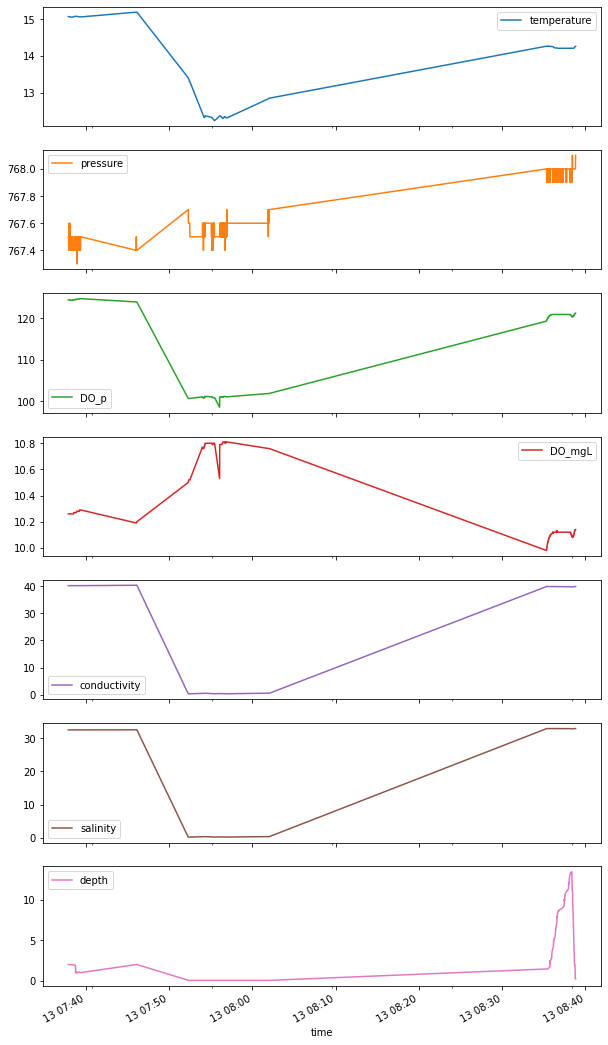

In [26]:
df.plot(subplots=True, figsize=(10, 20))